In [1]:
import matplotlib.pyplot as plt 
import xarray as xr 
import pandas as pd 
from pathlib import Path
from utils.read_files import read_from_control, make_default_path
import os
import geopandas as gpd
from metpy.units import units
import statsmodels.api as sm

In [2]:
# Store the name of the 'active' file in a variable
basin = "EastRiver"
controlFile = f'control_{basin}.txt'

In [3]:
experiment_id = read_from_control(controlFile, 'experiment_id')

In [4]:
# Paths - output folder
path_to_output = read_from_control(controlFile,'experiment_output_summa')

# Specify default path if needed
if path_to_output == 'default':  
    path_to_output = make_default_path('simulations/' + experiment_id + '/SUMMA', controlFile) # outputs a Path()
else:
    path_to_output = Path(path_to_output) # make sure a user-specified path is a Path()
    
# Make the folder if it doesn't exist
path_to_output.mkdir(parents=True, exist_ok=True)

In [5]:
# get file names from the output path
file_names = os.listdir(path_to_output)
# get the file that we want
output_file = [f for f in file_names if 'run1' in f][0]

# Read the output file
output_ds = xr.open_dataset(path_to_output / output_file)

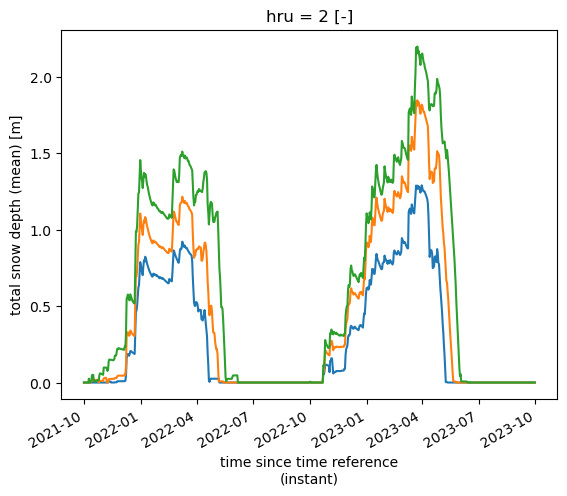

In [6]:
fig, ax = plt.subplots()
for hru in output_ds['LWRadAtm'].hru.values:
    (output_ds['scalarSnowDepth_mean']).sel(hru=hru).plot(ax=ax, label="HRU: " + str(hru))

In [7]:
# open the benchmark data
path_to_benchmark = read_from_control(controlFile, 'benchmark')

# Specify default path if needed
if path_to_benchmark == 'default':  
    path_to_benchmark = make_default_path('benchmark', controlFile) # outputs a Path()
else:
    path_to_benchmark = Path(path_to_benchmark) # make sure a user-specified path is a Path()

# get file names from the output path
benchmark_file_names = [f for f in os.listdir(path_to_benchmark) if os.path.isfile(os.path.join(path_to_benchmark, f))]

# Get the streamflow data file
streamflow_file = [f for f in benchmark_file_names if 'streamflow' in f][0]

# store the remaining files in a list
benchmark_file_names.remove(streamflow_file)

In [8]:
def read_benchmark_streamflow(path_to_benchmark, streamflow_file):
    # read the benchmark streamflow data
    benchmark_streamflow = pd.read_csv(path_to_benchmark / streamflow_file, index_col=0, parse_dates=True)
    # make the time the beginning of the day
    benchmark_streamflow.index = benchmark_streamflow.index.normalize()
    # remove timezone information
    benchmark_streamflow.index = benchmark_streamflow.index.tz_localize(None)
    # rename the column to streamflow
    benchmark_streamflow.columns = ['streamflow']
    # convert the units to mm/day
    benchmark_streamflow['streamflow'] = benchmark_streamflow['streamflow'] * units('mm/day')
    return benchmark_streamflow

q_df = read_benchmark_streamflow(path_to_benchmark, streamflow_file)

In [9]:
def read_benchmark_snow(file_name):
    """
    Read the benchmark snow telemetry data
    """
    # read the data
    df = pd.read_csv(path_to_benchmark / file_name, index_col=0)

    # convert units
    for col in df.columns:
        if "units" in col:
            name = col.split("_")[0]
            if "in" in list(df[col].unique()):
             
                df[name] = df[name] * 25.4
                df[col] = "mm"
            elif "degF" in list(df[col].unique()):
                df[name] = (df[name] - 32) * 5/9
                df[col] = "degC"
    # convert to xarray and save unit columns as attributes
    cols_without_units = [col for col in df.columns if "units" not in col]
    cols_with_units = [col for col in df.columns if "units" in col]
    ds = df[cols_without_units].to_xarray()
    for col in cols_without_units:
        if col + "_units" in cols_with_units:
            ds[col].attrs["units"] = df[col + "_units"].unique()[0]
    # add a site coordinate equal to the name of the file
    ds["site"] = str(file_name).split(".")[0].split("OBS_")[1]
    print(str(file_name).split(".")[0].split("OBS_")[1])
    # add to coordinates
    ds = ds.assign_coords(site=ds.site)
    # convert site dtype to string
    ds["site"] = ds.site.astype(str)
    # rename the datetime to time
    ds = ds.rename({"datetime": "time"})
    # convert the time to a datetime object
    ds["time"] = ds.time.astype("datetime64")
    return ds

snotel_list = []
for site in benchmark_file_names:
    snotel_list.append(read_benchmark_snow(site))
snotel_ds = xr.concat(snotel_list, dim="site")

BUTTE
SCHOFIELD_PASS


/tmp/ipykernel_4251/659234199.py:36: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds["time"] = ds.time.astype("datetime64")
/tmp/ipykernel_4251/659234199.py:36: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond

In [10]:
routed_runoff = output_ds['averageRoutedRunoff'].metpy.convert_units('mm/day').squeeze().to_dataframe()

Text(0, 0.5, 'Cumulative Density')

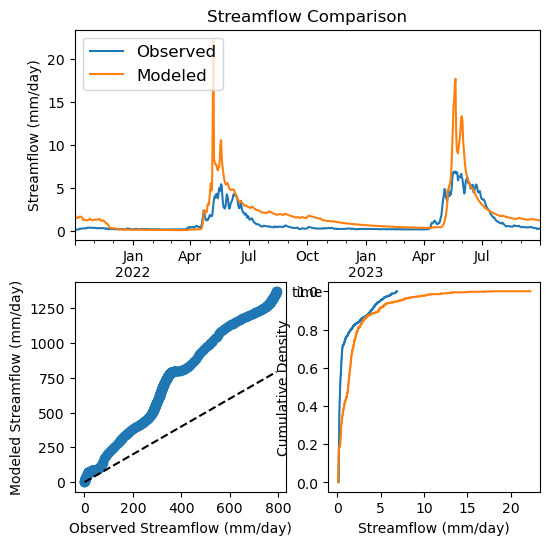

In [14]:
# plot 3 comparison plots
# 1. line plot of streamflow
# 2. scatter plot of streamflow with 1:1 line
# 3. Compare the CDF of daily streamflow values
# make the line plot the width of the figure and split the figure in half for the scatter and qq plot

# import grid spec
from matplotlib import gridspec

fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1])

# line plot
ax0 = plt.subplot(gs[0,:])
q_df.iloc[1:]['streamflow'].plot(ax=ax0, label='Observed')
routed_runoff.iloc[1:]['averageRoutedRunoff'].plot(ax=ax0, label='Modeled')
ax0.set_ylabel('Streamflow (mm/day)')
ax0.set_title('Streamflow Comparison')
ax0.legend(fontsize=12, loc='upper left')

# cumulative-cumulative plot
ax1 = plt.subplot(gs[1,0])
ax1.scatter(q_df.iloc[1:].cumsum(), routed_runoff['averageRoutedRunoff'].iloc[1:].cumsum())
ax1.plot([0, q_df['streamflow'].iloc[1:].sum()], [0, q_df['streamflow'].iloc[1:].sum()], 'k--')
ax1.set_xlabel('Observed Streamflow (mm/day)')
ax1.set_ylabel('Modeled Streamflow (mm/day)')

# CDFs
ax2 = plt.subplot(gs[1,1])
# plot the CDF
ecdf = sm.distributions.ECDF(q_df['streamflow'].iloc[1:].values)
ax2.step(ecdf.x, ecdf.y, label='Observed')
ecdf = sm.distributions.ECDF(routed_runoff['averageRoutedRunoff'].iloc[1:].values)
ax2.step(ecdf.x, ecdf.y, label='Modeled')
ax2.set_xlabel('Streamflow (mm/day)')
ax2.set_ylabel('Cumulative Density')



In [12]:
# calculate NSE
import numpy as np
def nse(obs, sim):
    return 1 - (np.sum((obs - sim)**2) / np.sum((obs - np.mean(obs))**2))

nse_val = nse(q_df['streamflow'].iloc[1:], routed_runoff['averageRoutedRunoff'].iloc[1:])
nse_val

-0.12385540360448477

Text(0.5, 1.0, 'SWE Comparison')

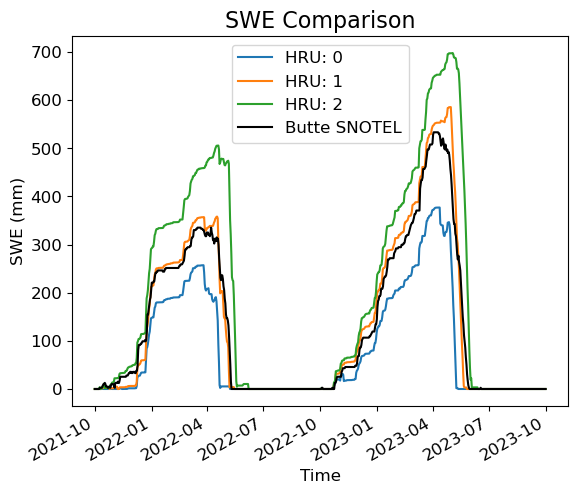

In [16]:
fig, ax = plt.subplots()
for hru in output_ds['scalarSWE'].hru.values:
    output_ds['scalarSWE'].sel(hru=hru).plot(ax=ax, label="HRU: " + str(hru))

snotel_ds.sel(site='BUTTE')["SWE"].plot(ax=ax, label="Butte SNOTEL", color='k')
ax.legend(fontsize=12, loc='upper center')
# increase the size of the x-axis text and labels and y-axis labels
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_ylabel('SWE (mm)', fontsize=12)
ax.set_xlabel('Time', fontsize=12)
ax.set_title('SWE Comparison', fontsize=16)
